<a href="https://colab.research.google.com/github/sVanshika/Cricket-Team-Selection/blob/main/DataScienceProject.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Importing libraries

In [231]:
import pandas as pd
import numpy as np
import missingno
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
#!pip install scikit-multilearn
from skmultilearn.problem_transform import BinaryRelevance
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
import matplotlib.pyplot as plt
from sklearn.metrics import multilabel_confusion_matrix
import seaborn as sns
from sklearn.metrics import classification_report

## Importing data

In [11]:
playerPerformance = pd.read_csv('https://raw.githubusercontent.com/sVanshika/Cricket-Team-Selection/main/data/Player_performance.csv')
match = pd.read_csv('https://raw.githubusercontent.com/sVanshika/Cricket-Team-Selection/main/data/Match.csv')

Let's change the column name in playerPerformance csv to match that of match csv

In [12]:
playerPerformance = playerPerformance.rename(columns={'Matchid':'Match_id'})

In [84]:
playerPerformance.iloc[:, 0:22].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1905 entries, 0 to 1904
Data columns (total 22 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Unnamed: 0       1905 non-null   int64  
 1   Match_id         1905 non-null   int64  
 2   Players_1        1905 non-null   object 
 3   BattingOrder_1   1905 non-null   int64  
 4   inning_bat_1     1905 non-null   float64
 5   Bat_Bowler_1     1905 non-null   object 
 6   Bat_Dismissal_1  1905 non-null   object 
 7   Bat_Runs_1       1905 non-null   float64
 8   4s_1             1905 non-null   float64
 9   6s_1             1905 non-null   float64
 10  Ball Faced_1     1905 non-null   float64
 11  Dots_1           1905 non-null   float64
 12  BattingTeam_1    1905 non-null   object 
 13  inning_bowl_1    1905 non-null   float64
 14  Over_1           1905 non-null   object 
 15  Runs_1           1905 non-null   object 
 16  Wicket_1         1905 non-null   object 
 17  Maiden_1      

In [86]:
print("The dimensions of playerPerformance.csv: ", playerPerformance.shape)

The dimensions of playerPerformance.csv:  (1905, 442)


In [88]:
playerPerformance.head()

,Unnamed: 0,Match_id,Players_1,BattingOrder_1,inning_bat_1,Bat_Bowler_1,Bat_Dismissal_1,Bat_Runs_1,4s_1,6s_1,Ball Faced_1,Dots_1,BattingTeam_1,inning_bowl_1,Over_1,Runs_1,Wicket_1,Maiden_1,extra_1,fowRuns_1,wicketNumber_1,fowOver_1,Players_2,BattingOrder_2,inning_bat_2,Bat_Bowler_2,Bat_Dismissal_2,Bat_Runs_2,4s_2,6s_2,Ball Faced_2,Dots_2,BattingTeam_2,inning_bowl_2,Over_2,Runs_2,Wicket_2,Maiden_2,extra_2,fowRuns_2,...,Players_21,BattingOrder_21,inning_bat_21,Bat_Bowler_21,Bat_Dismissal_21,Bat_Runs_21,4s_21,6s_21,Ball Faced_21,Dots_21,BattingTeam_21,inning_bowl_21,Over_21,Runs_21,Wicket_21,Maiden_21,extra_21,fowRuns_21,wicketNumber_21,fowOver_21,Players_22,BattingOrder_22,inning_bat_22,Bat_Bowler_22,Bat_Dismissal_22,Bat_Runs_22,4s_22,6s_22,Ball Faced_22,Dots_22,BattingTeam_22,inning_bowl_22,Over_22,Runs_22,Wicket_22,Maiden_22,extra_22,fowRuns_22,wicketNumber_22,fowOver_22
0,0,1004261,G Malla,1,1.0,T van der Gugten,bowled,11.0,2.0,0.0,12.0,8.0,Nepal,2.0,-,-,-,-,-,23.0,1.0,4.2,AK Mandal,2,1.0,RE van der Merwe,caught and bowled,20.0,1.0,0.0,39.0,30.0,Nepal,2.0,-,-,-,-,-,38.0,...,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-
1,1,1004269,C Carter,1,1.0,LN Oluoch,caught,41.0,4.0,1.0,62.0,41.0,Hong Kong,2.0,-,-,-,-,-,127.0,3.0,23.2,KD Shah,2,1.0,LN Oluoch,bowled,1.0,0.0,0.0,3.0,2.0,Hong Kong,2.0,-,-,-,-,-,2.0,...,NM Odhiambo,10,2.0,Nadeem Ahmed,caught,11.0,1.0,1.0,6.0,3.0,Kenya,1.0,4.0,33.0,1.0,0.0,4.0,133.0,10.0,22.6,LN Oluoch,11,2.0,-,not out,1.0,0.0,0.0,2.0,1.0,Kenya,1.0,6.1,29.0,3.0,0.0,0.0,-,-,-
2,2,1004283,KJ Coetzer,1,1.0,Ehsan Khan,lbw,53.0,6.0,2.0,29.0,9.0,Scotland,2.0,-,-,-,-,-,96.0,3.0,9.1,CD Wallace,2,1.0,Ehsan Khan,lbw,14.0,1.0,1.0,8.0,4.0,Scotland,2.0,-,-,-,-,-,38.0,...,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-
3,3,1004285,KJ Coetzer,1,1.0,Tanveer Ahmed,caught and bowled,48.0,8.0,2.0,41.0,28.0,Scotland,2.0,-,-,-,-,-,63.0,2.0,11.1,MH Cross,2,1.0,Nadeem Ahmed,caught,13.0,1.0,0.0,22.0,16.0,Scotland,2.0,-,-,-,-,-,63.0,...,Nadeem Ahmed,10,2.0,AC Evans,bowled,14.0,2.0,0.0,11.0,4.0,Hong Kong,1.0,10.0,37.0,1.0,0.0,0.0,213.0,10.0,46.1,Tanveer Ahmed,11,2.0,-,not out,0.0,0.0,0.0,1.0,1.0,Hong Kong,1.0,10.0,46.0,3.0,1.0,7.0,-,-,-
4,4,1007649,PJ Moor,1,1.0,BB Sran,lbw,3.0,0.0,0.0,5.0,3.0,Zimbabwe,2.0,-,-,-,-,-,8.0,1.0,1.7,CJ Chibhabha,2,1.0,JJ Bumrah,bowled,13.0,0.0,0.0,41.0,38.0,Zimbabwe,2.0,8.0,13.0,0.0,1.0,2.0,47.0,...,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-


In [174]:
match.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1951 entries, 0 to 1950
Data columns (total 25 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Unnamed: 0          1951 non-null   int64  
 1   Match_id            1951 non-null   int64  
 2   Team1               1951 non-null   object 
 3   Team2               1951 non-null   object 
 4   Gender              1951 non-null   object 
 5   Date                1951 non-null   object 
 6   Season              1951 non-null   object 
 7   Series/Competition  1921 non-null   object 
 8   Match_number        1704 non-null   float64
 9   Venue               1951 non-null   object 
 10  City                1664 non-null   object 
 11  Neutral_venue       517 non-null    object 
 12  Toss_winner         1951 non-null   object 
 13  Toss_decision       1951 non-null   object 
 14  Player_of_match     1809 non-null   object 
 15  Umpire1             1951 non-null   object 
 16  Umpire

In [175]:
match.head()

,Unnamed: 0,Match_id,Team1,Team2,Gender,Date,Season,Series/Competition,Match_number,Venue,City,Neutral_venue,Toss_winner,Toss_decision,Player_of_match,Umpire1,Umpire2,Reserve_umpire,Tv_umpire,Match_referee,Winner,Winner_runs,Winner_wickets,Method,Outcome
0,0,1000887,Australia,Pakistan,male,2017/01/13,2016/17,Pakistan in Australia ODI Series,1.0,"""Brisbane Cricket Ground",Brisbane,NaN,Australia,bat,MS Wade,MD Martell,C Shamshuddin,SJ Nogajski,CB Gaffaney,JJ Crowe,Australia,92.0,NaN,NaN,NaN
1,1,1000889,Australia,Pakistan,male,2017/01/15,2016/17,Pakistan in Australia ODI Series,2.0,Melbourne Cricket Ground,NaN,NaN,Australia,bat,Mohammad Hafeez,CB Gaffaney,P Wilson,SJ Nogajski,C Shamshuddin,JJ Crowe,Pakistan,NaN,6.0,NaN,NaN
2,2,1000891,Australia,Pakistan,male,2017/01/19,2016/17,Pakistan in Australia ODI Series,3.0,Western Australia Cricket Association Ground,Perth,NaN,Australia,field,SPD Smith,SD Fry,C Shamshuddin,P Wilson,CB Gaffaney,JJ Crowe,Australia,NaN,7.0,NaN,NaN
3,3,1000893,Australia,Pakistan,male,2017/01/22,2016/17,Pakistan in Australia ODI Series,4.0,Sydney Cricket Ground,NaN,NaN,Australia,bat,DA Warner,CB Gaffaney,MD Martell,P Wilson,C Shamshuddin,JJ Crowe,Australia,86.0,NaN,NaN,NaN
4,4,1000895,Australia,Pakistan,male,2017/01/26,2016/17,Pakistan in Australia ODI Series,5.0,Adelaide Oval,NaN,NaN,Australia,bat,DA Warner,SD Fry,C Shamshuddin,SJ Nogajski,CB Gaffaney,JJ Crowe,Australia,57.0,NaN,NaN,NaN


# Data Pre-Processing

## Merging the two data files

In [176]:
# merging playerPerformance data and matches data on 'match id' column
merged = playerPerformance.merge(match, how="inner", on='Match_id')

# dropping columns
dropFeatures = []
for col in merged.columns:
  if not (('Players' in col) or (col=='Match_id') or (col=='Gender') or (col=='BattingTeam_1') or (col=='BattingTeam_12') or (col=='Team1') or (col=='Team2') or (col=='Date') or (col=='Season') or (col=='Venue') or (col=='City') or (col=='Toss_winner') or (col=='Toss_decision') or (col=='Player_of_match') or ('Winner' in col) or (col=='Outcome')):
    dropFeatures.append(col)

# dropping columns
merged = merged.drop(dropFeatures, axis=1)

merged.head()

,Match_id,Players_1,BattingTeam_1,Players_2,Players_3,Players_4,Players_5,Players_6,Players_7,Players_8,Players_9,Players_10,Players_11,Players_12,BattingTeam_12,Players_13,Players_14,Players_15,Players_16,Players_17,Players_18,Players_19,Players_20,Players_21,Players_22,Team1,Team2,Gender,Date,Season,Venue,City,Toss_winner,Toss_decision,Player_of_match,Winner,Winner_runs,Winner_wickets,Outcome
0,1004261,G Malla,Nepal,AK Mandal,S Vesawkar,P Khadka,Sagar Pun,R Rijal,B Bhandari,Sompal Kami,B Regmi,Karan KC,S Lamichhane,SJ Myburgh,Netherlands,MJG Rippon,W Barresi,BN Cooper,RE van der Merwe,T van der Gugten,Mudassar Bukhari,Ahsan Malik,PA van Meekeren,-,-,Netherlands,Nepal,male,2016/08/13,2016,VRA Ground,Amstelveen,Netherlands,field,NaN,Netherlands,NaN,7.0,NaN
1,1004269,C Carter,Hong Kong,KD Shah,Babar Hayat,Nizakat Khan,Anshuman Rath,Tanwir Afzal,Nadeem Ahmed,Aizaz Khan,Ehsan Khan,Tanveer Ahmed,-,IA Karim,Kenya,AA Obanda,DM Gondaria,RR Patel,CO Obuya,NK Patel,Gurdeep Singh,NN Odhiambo,SO Ngoche,NM Odhiambo,LN Oluoch,Kenya,Hong Kong,male,2016/11/20,2016/17,Gymkhana Club Ground,Nairobi,Kenya,field,Babar Hayat,Hong Kong,39.0,NaN,NaN
2,1004283,KJ Coetzer,Scotland,CD Wallace,CS MacLeod,MH Cross,RD Berrington,PL Mommsen,CD de Lange,SM Sharif,CB Sole,AC Evans,MRJ Watt,Nizakat Khan,Hong Kong,Aizaz Khan,Babar Hayat,Anshuman Rath,Ehsan Khan,Tanwir Afzal,Nadeem Ahmed,Tanveer Ahmed,-,-,-,Scotland,Hong Kong,male,2016/09/08,2016,"""Grange Cricket Club Ground",Edinburgh,Hong Kong,field,NaN,NaN,NaN,NaN,no result
3,1004285,KJ Coetzer,Scotland,MH Cross,CS MacLeod,MA Leask,RD Berrington,CD de Lange,CD Wallace,SM Sharif,MRJ Watt,AC Evans,CB Sole,C Carter,Hong Kong,Aizaz Khan,Babar Hayat,Nizakat Khan,Anshuman Rath,Ehsan Khan,Shahid Wasif,Waqas Khan,Tanwir Afzal,Nadeem Ahmed,Tanveer Ahmed,Scotland,Hong Kong,male,2016/09/10,2016,"""Grange Cricket Club Ground",Edinburgh,Scotland,bat,NaN,Scotland,53.0,NaN,NaN
4,1007649,PJ Moor,Zimbabwe,CJ Chibhabha,H Masakadza,CR Ervine,V Sibanda,Sikandar Raza,E Chigumbura,R Mutumbami,AG Cremer,TL Chatara,T Muzarabani,KL Rahul,India,KK Nair,AT Rayudu,DS Kulkarni,BB Sran,JJ Bumrah,AR Patel,YS Chahal,-,-,-,Zimbabwe,India,male,2016/06/11,2016,Harare Sports Club,NaN,India,field,KL Rahul,India,NaN,9.0,NaN


In [177]:
#Taking only male players in consideration
merged = merged.loc[merged['Gender']=='male']
merged.reset_index(inplace=True, drop=True)
merged.shape

(1733, 39)

## Missing values

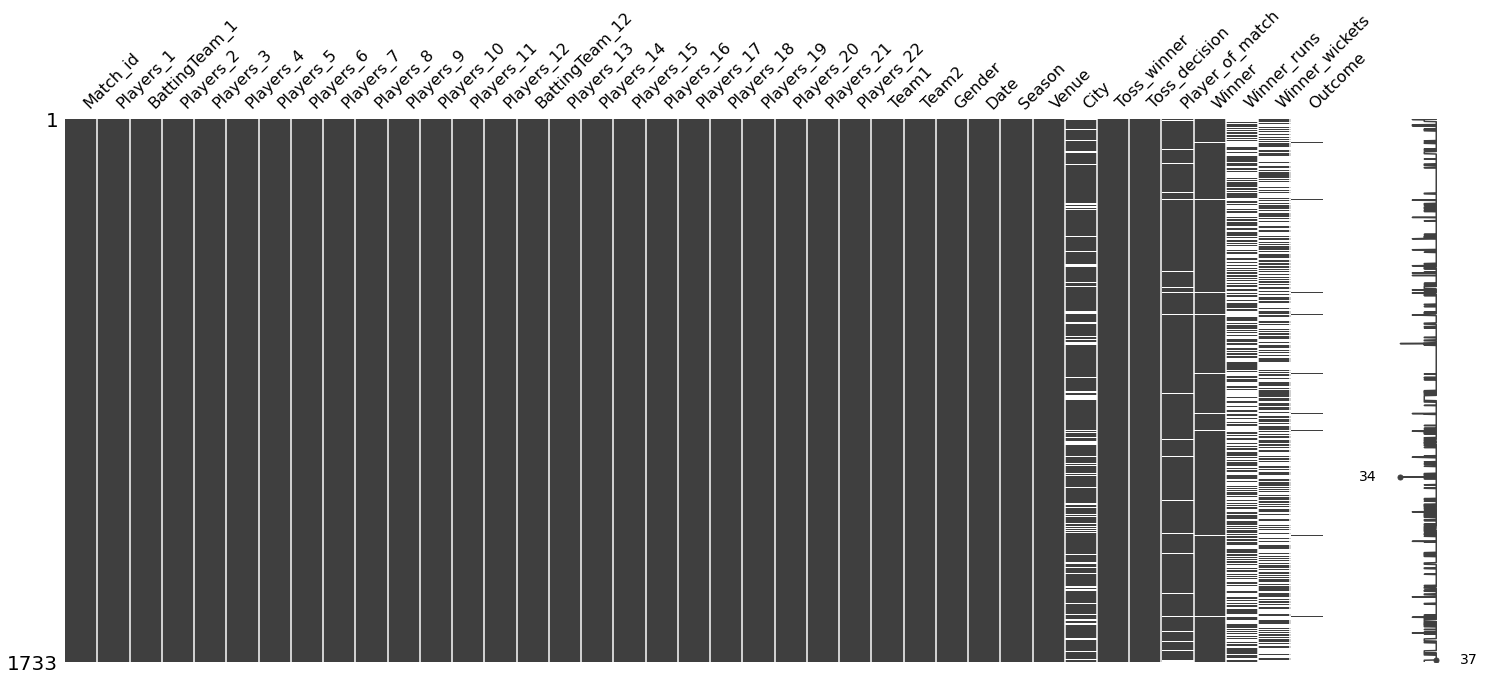

In [178]:
#visualizing missing values
missingno.matrix(merged)

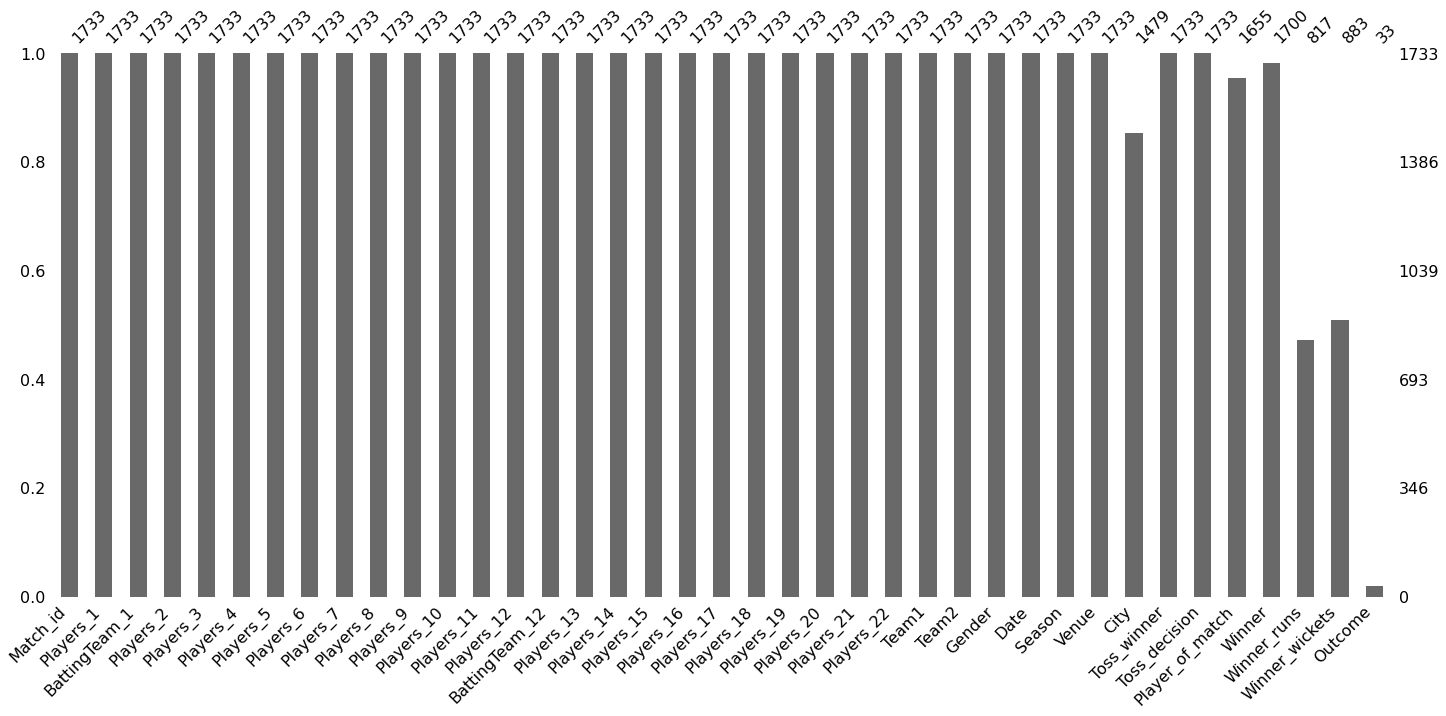

In [179]:
missingno.bar(merged)

In [180]:
# features containing missing values
for col in merged.isnull().sum().items():
  if (col[1] != 0):
    print(col)

('City', 254)
('Player_of_match', 78)
('Winner', 33)
('Winner_runs', 916)
('Winner_wickets', 850)
('Outcome', 1700)


In [181]:
'''
Null values:
1. City
2. Player of match
3. Winner
4. Winner runs
5. Winner wickets
6. Outcomes 
'''

# Winer and Outcomes (related)
merged.loc[ merged['Outcome'] == 'no result' , 'Winner'] = 'None'
merged.loc[ merged['Outcome'] == 'tie' , 'Winner'] = 'Tie'

merged = merged.drop('Outcome', axis=1)

#City
merged.loc[merged['City'].isnull(), 'City'] = 'Not Known'

#Player of match
merged.loc[merged['Player_of_match'].isnull(), 'Player_of_match'] = 'Not Known'

#Winner runs
meanRuns = int(merged['Winner_runs'].mean())
merged.loc[merged['Winner_runs'].isnull(), 'Winner_runs'] = meanRuns

#winner wickets
meanWickets = int(merged['Winner_wickets'].mean())
merged.loc[merged['Winner_wickets'].isnull(), 'Winner_wickets'] = meanWickets

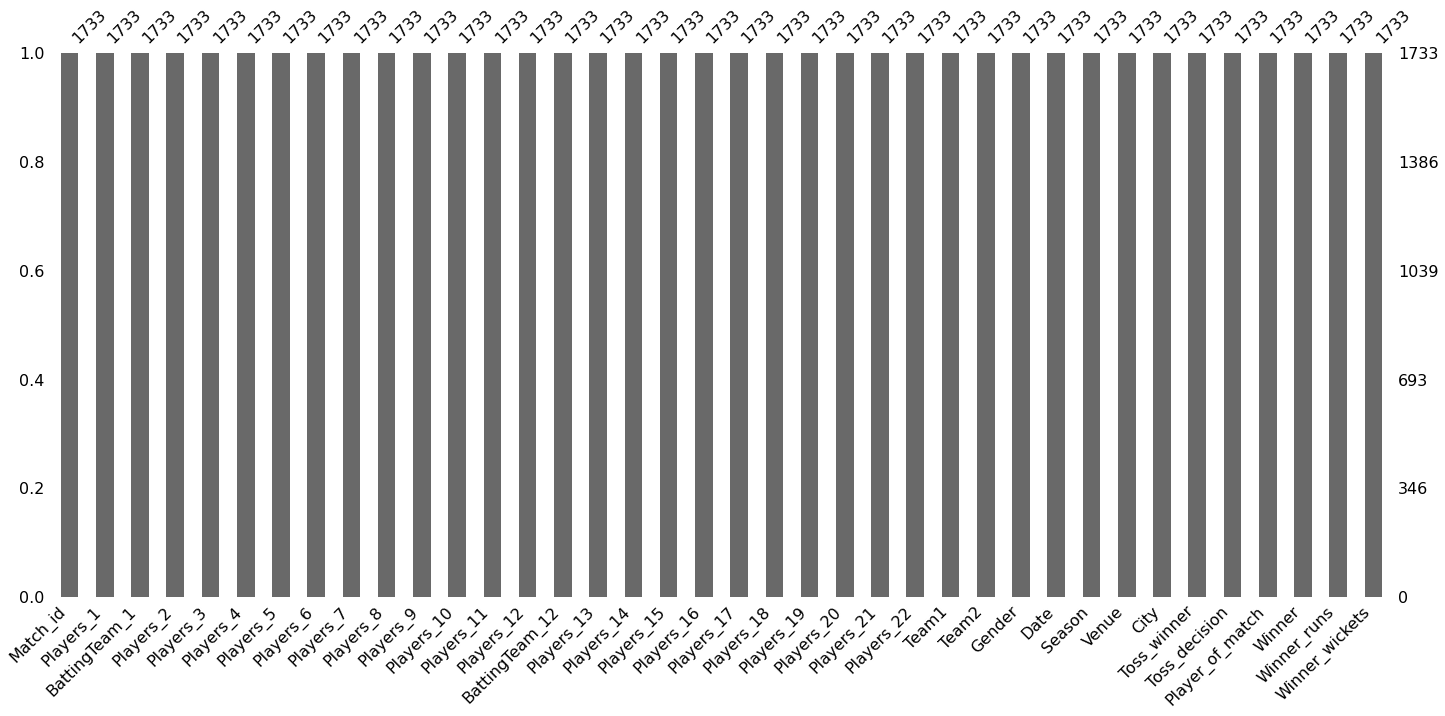

In [182]:
missingno.bar(merged)

In [183]:
merged.head()

,Match_id,Players_1,BattingTeam_1,Players_2,Players_3,Players_4,Players_5,Players_6,Players_7,Players_8,Players_9,Players_10,Players_11,Players_12,BattingTeam_12,Players_13,Players_14,Players_15,Players_16,Players_17,Players_18,Players_19,Players_20,Players_21,Players_22,Team1,Team2,Gender,Date,Season,Venue,City,Toss_winner,Toss_decision,Player_of_match,Winner,Winner_runs,Winner_wickets
0,1004261,G Malla,Nepal,AK Mandal,S Vesawkar,P Khadka,Sagar Pun,R Rijal,B Bhandari,Sompal Kami,B Regmi,Karan KC,S Lamichhane,SJ Myburgh,Netherlands,MJG Rippon,W Barresi,BN Cooper,RE van der Merwe,T van der Gugten,Mudassar Bukhari,Ahsan Malik,PA van Meekeren,-,-,Netherlands,Nepal,male,2016/08/13,2016,VRA Ground,Amstelveen,Netherlands,field,Not Known,Netherlands,66.0,7.0
1,1004269,C Carter,Hong Kong,KD Shah,Babar Hayat,Nizakat Khan,Anshuman Rath,Tanwir Afzal,Nadeem Ahmed,Aizaz Khan,Ehsan Khan,Tanveer Ahmed,-,IA Karim,Kenya,AA Obanda,DM Gondaria,RR Patel,CO Obuya,NK Patel,Gurdeep Singh,NN Odhiambo,SO Ngoche,NM Odhiambo,LN Oluoch,Kenya,Hong Kong,male,2016/11/20,2016/17,Gymkhana Club Ground,Nairobi,Kenya,field,Babar Hayat,Hong Kong,39.0,5.0
2,1004283,KJ Coetzer,Scotland,CD Wallace,CS MacLeod,MH Cross,RD Berrington,PL Mommsen,CD de Lange,SM Sharif,CB Sole,AC Evans,MRJ Watt,Nizakat Khan,Hong Kong,Aizaz Khan,Babar Hayat,Anshuman Rath,Ehsan Khan,Tanwir Afzal,Nadeem Ahmed,Tanveer Ahmed,-,-,-,Scotland,Hong Kong,male,2016/09/08,2016,"""Grange Cricket Club Ground",Edinburgh,Hong Kong,field,Not Known,None,66.0,5.0
3,1004285,KJ Coetzer,Scotland,MH Cross,CS MacLeod,MA Leask,RD Berrington,CD de Lange,CD Wallace,SM Sharif,MRJ Watt,AC Evans,CB Sole,C Carter,Hong Kong,Aizaz Khan,Babar Hayat,Nizakat Khan,Anshuman Rath,Ehsan Khan,Shahid Wasif,Waqas Khan,Tanwir Afzal,Nadeem Ahmed,Tanveer Ahmed,Scotland,Hong Kong,male,2016/09/10,2016,"""Grange Cricket Club Ground",Edinburgh,Scotland,bat,Not Known,Scotland,53.0,5.0
4,1007649,PJ Moor,Zimbabwe,CJ Chibhabha,H Masakadza,CR Ervine,V Sibanda,Sikandar Raza,E Chigumbura,R Mutumbami,AG Cremer,TL Chatara,T Muzarabani,KL Rahul,India,KK Nair,AT Rayudu,DS Kulkarni,BB Sran,JJ Bumrah,AR Patel,YS Chahal,-,-,-,Zimbabwe,India,male,2016/06/11,2016,Harare Sports Club,Not Known,India,field,KL Rahul,India,66.0,9.0


## Feature Engineering


In [185]:
#defining new dataframe
df = merged[['Match_id', 'Team1', 'Team2', 'Date', 'Season', 'Venue', 'City', 'Toss_winner', 'Toss_decision', 'Player_of_match', 'Winner', 'Winner_runs', 'Winner_wickets']]

#combining players and putting it in one column
playersTeam1 = []
playersTeam2 = []

for i in range(len(merged)):
    row = merged.loc[i]
    temp1 = []
    temp2 = []

    for j in range(1, 12):
        title = "Players_"+str(j)
        temp1.append(row[title])
        title = "Players_"+str(j+11)
        temp2.append(row[title])
    
    if row['BattingTeam_1'] == row['Team1']:
        playersTeam1.append(temp1)
        playersTeam2.append(temp2)
    else:
        playersTeam1.append(temp2)
        playersTeam2.append(temp1)

df['PlayersTeam1'] = playersTeam1
df['PlayersTeam2'] = playersTeam2

df = df.rename(columns={"Team1": "Team", "PlayersTeam1": "Players"})

df.head()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


,Match_id,Team,Team2,Date,Season,Venue,City,Toss_winner,Toss_decision,Player_of_match,Winner,Winner_runs,Winner_wickets,Players,PlayersTeam2
0,1004261,Netherlands,Nepal,2016/08/13,2016,VRA Ground,Amstelveen,Netherlands,field,Not Known,Netherlands,66.0,7.0,"[SJ Myburgh, MJG Rippon, W Barresi, BN Cooper,...","[G Malla, AK Mandal, S Vesawkar, P Khadka, Sag..."
1,1004269,Kenya,Hong Kong,2016/11/20,2016/17,Gymkhana Club Ground,Nairobi,Kenya,field,Babar Hayat,Hong Kong,39.0,5.0,"[IA Karim, AA Obanda, DM Gondaria, RR Patel, C...","[C Carter, KD Shah, Babar Hayat, Nizakat Khan,..."
2,1004283,Scotland,Hong Kong,2016/09/08,2016,"""Grange Cricket Club Ground",Edinburgh,Hong Kong,field,Not Known,None,66.0,5.0,"[KJ Coetzer, CD Wallace, CS MacLeod, MH Cross,...","[Nizakat Khan, Aizaz Khan, Babar Hayat, Anshum..."
3,1004285,Scotland,Hong Kong,2016/09/10,2016,"""Grange Cricket Club Ground",Edinburgh,Scotland,bat,Not Known,Scotland,53.0,5.0,"[KJ Coetzer, MH Cross, CS MacLeod, MA Leask, R...","[C Carter, Aizaz Khan, Babar Hayat, Nizakat Kh..."
4,1007649,Zimbabwe,India,2016/06/11,2016,Harare Sports Club,Not Known,India,field,KL Rahul,India,66.0,9.0,"[PJ Moor, CJ Chibhabha, H Masakadza, CR Ervine...","[KL Rahul, KK Nair, AT Rayudu, DS Kulkarni, BB..."


In [186]:
''' creating new rows for team2 as team'''
for i in range(len(df)):
    row = df.loc[i]
    newRow = row.to_dict()
    newRow['Team'] = row['Team2']
    newRow['Players'] = row['PlayersTeam2']
    df = df.append(newRow, ignore_index=True)

df = df.drop(columns=['Team2', 'PlayersTeam2'])

In [187]:
df.head()

,Match_id,Team,Date,Season,Venue,City,Toss_winner,Toss_decision,Player_of_match,Winner,Winner_runs,Winner_wickets,Players
0,1004261,Netherlands,2016/08/13,2016,VRA Ground,Amstelveen,Netherlands,field,Not Known,Netherlands,66.0,7.0,"[SJ Myburgh, MJG Rippon, W Barresi, BN Cooper,..."
1,1004269,Kenya,2016/11/20,2016/17,Gymkhana Club Ground,Nairobi,Kenya,field,Babar Hayat,Hong Kong,39.0,5.0,"[IA Karim, AA Obanda, DM Gondaria, RR Patel, C..."
2,1004283,Scotland,2016/09/08,2016,"""Grange Cricket Club Ground",Edinburgh,Hong Kong,field,Not Known,None,66.0,5.0,"[KJ Coetzer, CD Wallace, CS MacLeod, MH Cross,..."
3,1004285,Scotland,2016/09/10,2016,"""Grange Cricket Club Ground",Edinburgh,Scotland,bat,Not Known,Scotland,53.0,5.0,"[KJ Coetzer, MH Cross, CS MacLeod, MA Leask, R..."
4,1007649,Zimbabwe,2016/06/11,2016,Harare Sports Club,Not Known,India,field,KL Rahul,India,66.0,9.0,"[PJ Moor, CJ Chibhabha, H Masakadza, CR Ervine..."


In [188]:
''' encoding for team names '''
def teamEncoding():
    uniqueTeams = df.Team.unique()
    encode = np.arange(len(uniqueTeams))

    uniqueTeamsDict = {}
    for i in range(len(uniqueTeams)):
        uniqueTeamsDict[uniqueTeams[i]] = encode[i]
    
    return uniqueTeamsDict

''' encoding for cities '''
def cityEncoding():
    uniqueCities = df.City.unique()
    encode = np.arange(len(uniqueCities))

    uniqueCitiesDict = {}
    for i in range(len(uniqueCities)):
        uniqueCitiesDict[uniqueCities[i]] = encode[i]

    return uniqueCitiesDict

''' encoding for toss decision '''
tossDecision = {'field':0, 'bat':1}

''' replacing columns with encoded data '''
uniqueTeamsDict = teamEncoding()
uniqueCitiesDict = cityEncoding()

df['Team'].replace(uniqueTeamsDict, inplace=True)
df['Toss_winner'].replace(uniqueTeamsDict, inplace=True)
df['Winner'].replace(uniqueTeamsDict, inplace=True)
df['City'].replace(uniqueCitiesDict, inplace=True)
df['Toss_decision'].replace(tossDecision, inplace=True)

In [189]:
df.head()

,Match_id,Team,Date,Season,Venue,City,Toss_winner,Toss_decision,Player_of_match,Winner,Winner_runs,Winner_wickets,Players
0,1004261,0,2016/08/13,2016,VRA Ground,0,0,0,Not Known,0,66.0,7.0,"[SJ Myburgh, MJG Rippon, W Barresi, BN Cooper,..."
1,1004269,1,2016/11/20,2016/17,Gymkhana Club Ground,1,1,0,Babar Hayat,18,39.0,5.0,"[IA Karim, AA Obanda, DM Gondaria, RR Patel, C..."
2,1004283,2,2016/09/08,2016,"""Grange Cricket Club Ground",2,18,0,Not Known,None,66.0,5.0,"[KJ Coetzer, CD Wallace, CS MacLeod, MH Cross,..."
3,1004285,2,2016/09/10,2016,"""Grange Cricket Club Ground",2,2,1,Not Known,2,53.0,5.0,"[KJ Coetzer, MH Cross, CS MacLeod, MA Leask, R..."
4,1007649,3,2016/06/11,2016,Harare Sports Club,3,9,0,KL Rahul,9,66.0,9.0,"[PJ Moor, CJ Chibhabha, H Masakadza, CR Ervine..."


### Indian team data

In [190]:
india = df.loc[df['Team'] == uniqueTeamsDict['India']][['Match_id', 'Team', 'City', 'Winner', 'Winner_runs', 'Winner_wickets', 'Players']]
india = india.reset_index(drop=True)

In [191]:
# encoding winning team
win = []
tie = []
for i in range(len(india)):
    row = india.loc[i]
    if row['Winner'] == 9:
        win.append(1)
        tie.append(0)
    elif row['Winner'] == 'Tie':
        tie.append(1)
        win.append(0)
    else:
        win.append(0)
        tie.append(0)
india['Win'] = win
india['Tie'] = tie

india = india.drop(['Team', 'Winner', 'Match_id'], axis=1)

In [192]:
# creating binary relevant target variable from multi label feature
def extractPlayers():
    Players = []
    for playerList in india['Players']:
        for player in playerList:
            if (not player in Players) and (player != '-'):
                Players.append(player)
    return Players

def playerDataframe():
    dfPlayers = {}
    for p in Players:
        dfPlayers[p] = [0]*len(india)
        
    for i in range(len(india)):
        playerList = india['Players'][i]
        for player in playerList:
            if player != '-':
                dfPlayers[player][i] = 1
    return dfPlayers

Players = extractPlayers()
dfPlayers = playerDataframe()

for keys, values in dfPlayers.items():
    india[keys] = values
india = india.drop(['Players'], axis=1)

In [193]:
india.head()

,City,Winner_runs,Winner_wickets,Win,Tie,RG Sharma,S Dhawan,V Kohli,Yuvraj Singh,HH Pandya,B Kumar,UT Yadav,JJ Bumrah,RA Jadeja,MS Dhoni,KM Jadhav,R Ashwin,AM Rahane,MK Pandey,AR Patel,A Mishra,DS Kulkarni,J Yadav,KL Rahul,Kuldeep Yadav,YS Chahal,V Shankar,Mohammed Shami,G Gambhir,V Sehwag,R Dravid,M Kaif,SK Raina,IK Pathan,Harbhajan Singh,RP Singh,S Sreesanth,RR Powar,MM Patel,AB Agarkar,...,I Sharma,PP Chawla,M Kartik,PP Ojha,YK Pathan,A Nehra,AM Nayar,S Tyagi,M Vijay,A Mithun,AB Dinda,NV Ojha,Pankaj Singh,SS Tiwary,R Vinay Kumar,WP Saha,PA Patel,VR Aaron,MK Tiwary,R Sharma,JD Unadkat,MM Sharma,AT Rayudu,STR Binny,KV Sharma,KK Nair,BB Sran,FY Fazal,RR Pant,Arshad Khan,Umar Gul,W Jaffer,VVS Laxman,MS Gony,S Badrinath,L Balaji,CA Pujara,Parvez Rasool,Gurkeerat Singh,R Dhawan
0,11,124.0,5.0,1,0,1,1,1,1,1,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,10,66.0,7.0,0,0,1,1,1,1,1,1,1,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,10,66.0,8.0,1,0,1,1,1,1,1,1,0,1,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,10,180.0,5.0,0,0,1,1,1,1,1,1,0,1,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,21,66.0,6.0,1,0,1,0,1,0,1,0,1,1,0,1,1,0,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


## Model

In [194]:
X = india[['City', 'Winner_runs', 'Winner_wickets', 'Win', 'Tie']]
Y = india.drop(['City', 'Winner_runs', 'Winner_wickets', 'Win', 'Tie'], axis=1)

In [195]:
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

In [203]:
# gaussian naive bayes

classifierGN = BinaryRelevance(GaussianNB())
classifierGN.fit(x_train, y_train)
# predicting values
predictions = classifierGN.predict(x_test)

In [198]:
''' logistic regression '''

# initialising model
classifer = BinaryRelevance(classifier = LogisticRegression())

# model fitting
classifier.fit(x_train, y_train)

# creating numpy array of x_test
test = x_test.to_numpy()

In [211]:
# probability prediction
predictions_prob = classifier.predict_proba(test)

In [205]:
predictions = pd.DataFrame(predictions.toarray())

In [206]:
# calculating accuracy 
sumAccuracy=[]
for i in range(len(y_test)):
    acc = accuracy_score(y_test[y_test.columns[i]], predictions[i])
    sumAccuracy.append(acc)

print("The mean accuracy of the model:",np.mean(sumAccuracy))

The mean accuracy of the model: 0.5408333333333334


In [207]:
confusionMatrix = multilabel_confusion_matrix(y_test, predictions)
for i in range(len(confusionMatrix)):
    print(Players[i])
    print(confusionMatrix[i])
    print("----------")

RG Sharma
[[ 7 27]
 [ 5 21]]
----------
S Dhawan
[[41  3]
 [16  0]]
----------
V Kohli
[[23  0]
 [36  1]]
----------
Yuvraj Singh
[[ 8 19]
 [ 2 31]]
----------
HH Pandya
[[23 32]
 [ 0  5]]
----------
B Kumar
[[48  1]
 [11  0]]
----------
UT Yadav
[[ 0 48]
 [ 1 11]]
----------
JJ Bumrah
[[23 33]
 [ 0  4]]
----------
RA Jadeja
[[33  4]
 [18  5]]
----------
MS Dhoni
[[11  0]
 [47  2]]
----------
KM Jadhav
[[25 29]
 [ 0  6]]
----------
R Ashwin
[[40  1]
 [18  1]]
----------
AM Rahane
[[44  1]
 [15  0]]
----------
MK Pandey
[[41 16]
 [ 2  1]]
----------
AR Patel
[[12 41]
 [ 0  7]]
----------
A Mishra
[[ 1 54]
 [ 0  5]]
----------
DS Kulkarni
[[38 19]
 [ 1  2]]
----------
J Yadav
[[60  0]
 [ 0  0]]
----------
KL Rahul
[[21 37]
 [ 0  2]]
----------
Kuldeep Yadav
[[23 36]
 [ 0  1]]
----------
YS Chahal
[[36 23]
 [ 0  1]]
----------
V Shankar
[[45 15]
 [ 0  0]]
----------
Mohammed Shami
[[51  1]
 [ 8  0]]
----------
G Gambhir
[[19 18]
 [ 9 14]]
----------
V Sehwag
[[37  7]
 [12  4]]
----------


In [160]:
classificationReport = classification_report(y_test, predictions, target_names=Players, zero_division=True)
print(classificationReport)

                 precision    recall  f1-score   support

      RG Sharma       0.44      0.81      0.57        26
       S Dhawan       0.00      0.00      0.00        16
        V Kohli       1.00      0.03      0.05        37
   Yuvraj Singh       0.62      0.94      0.75        33
      HH Pandya       0.14      1.00      0.24         5
        B Kumar       0.00      0.00      0.00        11
       UT Yadav       0.19      0.92      0.31        12
      JJ Bumrah       0.11      1.00      0.20         4
      RA Jadeja       0.56      0.22      0.31        23
       MS Dhoni       1.00      0.04      0.08        49
      KM Jadhav       0.17      1.00      0.29         6
       R Ashwin       0.50      0.05      0.10        19
      AM Rahane       0.00      0.00      0.00        15
      MK Pandey       0.06      0.33      0.10         3
       AR Patel       0.15      1.00      0.25         7
       A Mishra       0.08      1.00      0.16         5
    DS Kulkarni       0.10    

In [ ]:
predictions_prob = pd.DataFrame(predictions_prob.toarray())

In [217]:
p = np.arange(len(Players))
d={}
for key,playerName in zip(p, Players):
    d[key]=playerName

In [219]:
predictions_prob.rename(columns=d, inplace=True)

In [220]:
predictions_prob.head()

,RG Sharma,S Dhawan,V Kohli,Yuvraj Singh,HH Pandya,B Kumar,UT Yadav,JJ Bumrah,RA Jadeja,MS Dhoni,KM Jadhav,R Ashwin,AM Rahane,MK Pandey,AR Patel,A Mishra,DS Kulkarni,J Yadav,KL Rahul,Kuldeep Yadav,YS Chahal,V Shankar,Mohammed Shami,G Gambhir,V Sehwag,R Dravid,M Kaif,SK Raina,IK Pathan,Harbhajan Singh,RP Singh,S Sreesanth,RR Powar,MM Patel,AB Agarkar,Y Venugopal Rao,VRV Singh,RV Uthappa,SC Ganguly,SR Tendulkar,...,I Sharma,PP Chawla,M Kartik,PP Ojha,YK Pathan,A Nehra,AM Nayar,S Tyagi,M Vijay,A Mithun,AB Dinda,NV Ojha,Pankaj Singh,SS Tiwary,R Vinay Kumar,WP Saha,PA Patel,VR Aaron,MK Tiwary,R Sharma,JD Unadkat,MM Sharma,AT Rayudu,STR Binny,KV Sharma,KK Nair,BB Sran,FY Fazal,RR Pant,Arshad Khan,Umar Gul,W Jaffer,VVS Laxman,MS Gony,S Badrinath,L Balaji,CA Pujara,Parvez Rasool,Gurkeerat Singh,R Dhawan
0,0.494363,0.311634,0.010096,0.523815,0.196378,0.225305,0.958097,0.111822,0.348692,0.003065,0.033823,0.286663,0.052970,3.107776e-07,0.879600,0.955611,0.037926,0.0,0.481759,0.308848,0.615319,0.000000,0.150980,0.486772,0.162795,0.038161,0.015765,0.444133,0.973871,0.246384,0.147344,0.950270,0.820321,0.018206,0.830939,0.0,0.0,0.860511,0.929958,0.132926,...,0.969338,0.041140,0.866757,0.835019,0.080027,0.922006,0.0,0.0,0.680457,0.000000,0.456950,0.0,0.0,0.0,0.873874,1.883155e-05,0.045903,1.714810e-05,0.012657,0.000000,9.880495e-01,0.911694,0.850286,0.615591,0.0,0.0,6.946144e-23,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000422,0.0,6.640186e-02,0.0,1.871117e-05,1.871117e-05
1,0.706632,0.274055,0.020576,0.600241,0.897196,0.143961,0.978802,0.920777,0.412076,0.014896,0.944422,0.247688,0.141581,9.144543e-01,0.930790,0.912295,0.939454,0.0,0.851045,0.764467,0.845032,0.999983,0.147675,0.574363,0.315177,0.055479,0.792347,0.658592,0.971207,0.345106,0.038398,0.949156,0.894530,0.048402,0.723614,0.0,0.0,0.893280,0.619792,0.168318,...,0.978554,0.023752,0.369220,0.870982,0.097919,0.937995,0.0,0.0,0.872877,0.995915,0.895586,0.0,0.0,0.0,0.935065,9.991887e-01,0.015705,1.304272e-02,0.956889,0.999290,8.005526e-01,0.924591,0.954256,0.878128,0.0,0.0,0.000000e+00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.891982,0.0,9.946357e-01,0.0,7.459412e-01,7.459412e-01
2,0.409181,0.154157,0.007464,0.816210,0.005536,0.156115,0.787184,0.000170,0.175869,0.080292,0.014267,0.175703,0.052090,3.558057e-15,0.673634,0.912688,0.000004,0.0,0.005507,0.051975,0.018132,0.999957,0.125228,0.650643,0.505454,0.293208,0.922630,0.776567,0.968909,0.593139,0.227118,0.930346,0.746878,0.190157,0.970421,0.0,0.0,0.942966,0.948626,0.478708,...,0.966946,0.041392,0.397211,0.530684,0.167323,0.961914,0.0,0.0,0.883089,0.998502,0.469235,0.0,0.0,0.0,0.428797,9.997169e-01,0.007885,5.385594e-09,0.002634,0.973495,5.039957e-28,0.909690,0.603414,0.408629,0.0,0.0,0.000000e+00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.078735,0.0,2.985270e-16,0.0,2.325354e-02,2.325354e-02
3,0.764335,0.578500,0.020368,0.156452,0.644588,0.366158,0.992670,0.975469,0.736911,0.000384,0.052478,0.459261,0.075258,9.093598e-01,0.964544,0.969931,0.994914,0.0,0.968534,0.202918,0.983596,0.000000,0.275100,0.246656,0.040751,0.001535,0.000027,0.221043,0.955223,0.051133,0.028674,0.893459,0.173737,0.001640,0.159458,0.0,0.0,0.794166,0.735715,0.026913,...,0.967517,0.015084,0.601267,0.929432,0.019359,0.875342,0.0,0.0,0.549789,0.000000,0.082968,0.0,0.0,0.0,0.966639,1.256742e-12,0.020183,8.407315e-03,0.032288,0.000000,9.949940e-01,0.954361,0.969384,0.863581,0.0,0.0,9.999999e-01,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000004,0.0,9.993605e-01,0.0,1.356465e-09,1.356465e-09
4,0.710807,0.192227,0.011562,0.663036,0.942926,0.189987,0.944669,0.878452,0.299609,0.288966,0.957604,0.147138,0.154281,2.967879e-01,0.774732,0.881759,0.166392,0.0,0.820111,0.842493,0.384308,0.000000,0.073080,0.439430,0.526132,0.216534,0.946474,0.731780,0.957413,0.494607,0.067625,0.931747,0.332958,0.106121,0.933156,0.0,0.0,0.954829,0.800384,0.328402,...,0.977983,0.030594,0.679718,0.902838,0.114737,0.939204,0.0,0.0,0.781790,0.999154,0.745300,0.0,0.0,0.0,0.696823,0.000000e+00,0.018690,5.721240e-03,0.896679,0.998406,1.468079e-83,0.816480,0

In [236]:
for i in range(len(predictions_prob)):
    row = predictions_prob.loc[i]
    sortedRow = row.sort_values(axis=0, ascending=False)[:10]
    print(sortedRow)
    print("--------------------")

JD Unadkat     0.988049
KD Karthik     0.977565
IK Pathan      0.973871
I Sharma       0.969338
UT Yadav       0.958097
A Mishra       0.955611
S Sreesanth    0.950270
SC Ganguly     0.929958
A Nehra        0.922006
MM Sharma      0.911694
Name: 0, dtype: float64
--------------------
V Shankar     0.999983
R Sharma      0.999290
WP Saha       0.999189
A Mithun      0.995915
CA Pujara     0.994636
UT Yadav      0.978802
I Sharma      0.978554
IK Pathan     0.971207
KD Karthik    0.961907
MK Tiwary     0.956889
Name: 1, dtype: float64
--------------------
V Shankar     0.999957
WP Saha       0.999717
A Mithun      0.998502
R Sharma      0.973495
AB Agarkar    0.970421
IK Pathan     0.968909
I Sharma      0.966946
A Nehra       0.961914
SC Ganguly    0.948626
RV Uthappa    0.942966
Name: 2, dtype: float64
--------------------
BB Sran        1.000000
CA Pujara      0.999360
JD Unadkat     0.994994
DS Kulkarni    0.994914
KD Karthik     0.993531
UT Yadav       0.992670
YS Chahal      0.9835